### Referencec: https://www.youtube.com/watch?v=AunotauS5yI 

In [32]:
import numpy as np 
from sklearn.datasets import make_classification 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

In [21]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label1.set_fontsize(x_fontsize)
        tick.label1.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label1.set_fontsize(y_fontsize)
        tick.label1.set_rotation(y_rotation)

In [4]:
X, y = make_classification(
    n_samples=500, n_classes=2, n_features=10, n_redundant=0, n_informative=5, random_state=1,
)

In [5]:
X.shape, y.shape, type(X), type(y)

((500, 10), (500,), numpy.ndarray, numpy.ndarray)

In [11]:
train_frac = 0.5
test_frac = 0.3

train_X = X[: int(len(X) * train_frac)]
train_y = y[: int(len(X) * train_frac)]

test_X = X[int(len(X) * train_frac): int(len(X) * (train_frac + test_frac))]
test_y = y[int(len(X) * train_frac): int(len(X) * (train_frac + test_frac))]

valid_X = X[int(len(X) * (train_frac + test_frac)): ]
valid_y = y[int(len(X) * (train_frac + test_frac)): ]

train_X.shape, train_y.shape, test_X.shape, test_y.shape, valid_X.shape, valid_y.shape 

((250, 10), (250,), (150, 10), (150,), (100, 10), (100,))

In [12]:
clf = RandomForestClassifier()
clf.fit(train_X, train_y)

RandomForestClassifier()

In [15]:
pred_probs = {
    "train": clf.predict_proba(train_X)[:, 1],
    "test": clf.predict_proba(test_X)[:, 1],
    "valid": clf.predict_proba(valid_X)[:, 1],
}
pred_probs["train"].shape, pred_probs["test"].shape, pred_probs["valid"].shape

((250,), (150,), (100,))

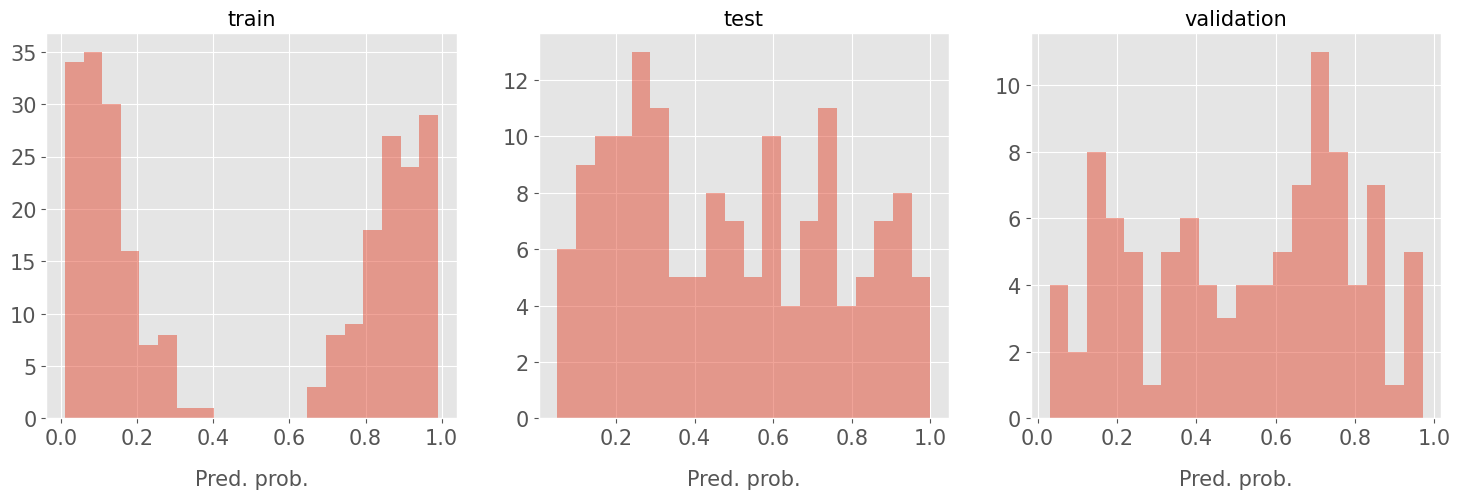

In [23]:
fontsize = 15
fig = plt.figure(figsize=(18, 5))
gs = matplotlib.gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0, 0])
ax.hist(pred_probs["train"], bins=20, alpha=0.5)
ax.set_title("train", fontsize=fontsize)
ax.set_xlabel("Pred. prob.", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)

ax = plt.subplot(gs[0, 1])
ax.hist(pred_probs["test"], bins=20, alpha=0.5)
ax.set_title("test", fontsize=fontsize)
ax.set_xlabel("Pred. prob.", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)

ax = plt.subplot(gs[0, 2])
ax.hist(pred_probs["valid"], bins=20, alpha=0.5)
ax.set_title("validation", fontsize=fontsize)
ax.set_xlabel("Pred. prob.", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)

Text(0.5, 1.0, 'Reliability curve')

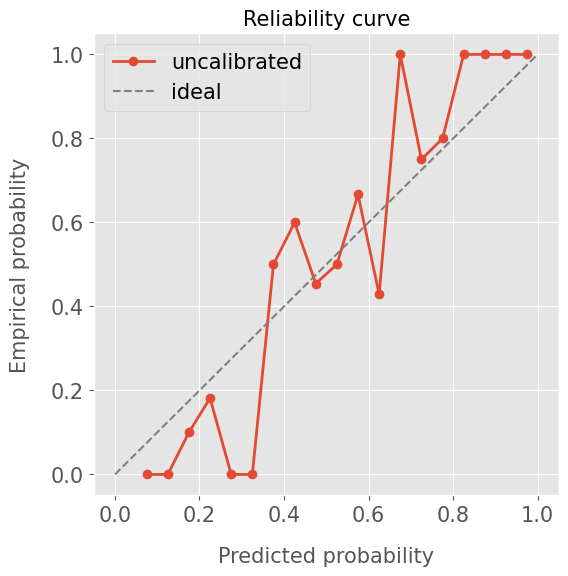

In [45]:
pred_probs_space = np.linspace(
    pred_probs["test"].min(),
    pred_probs["test"].max(),    
    20,
)
empirical_probs = []
pred_probs_midpoints = []
for i in range(len(pred_probs_space) - 1):
    empirical_probs.append(
        np.mean(test_y[(pred_probs["test"] > pred_probs_space[i]) & (pred_probs["test"] < pred_probs_space[i+1])])
    )
    pred_probs_midpoints.append(
      (pred_probs_space[i] + pred_probs_space[i + 1]) / 2.
    )

fig, ax = plt.subplots(1, figsize=(6, 6))

ax.plot(pred_probs_midpoints, empirical_probs, lw=2., marker="o", label="uncalibrated")
ax.plot([0,1], [0,1], linestyle='--', color="gray", label="ideal")
ax.set_xlabel("Predicted probability", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Empirical probability", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_title("Reliability curve", fontsize=fontsize)

In [46]:
lr = LogisticRegression()
lr.fit(pred_probs["test"].reshape(-1, 1), test_y)

LogisticRegression()

In [47]:
pred_probs_space = np.linspace(
    pred_probs["valid"].min(),
    pred_probs["valid"].max(),    
    20,
)
empirical_probs = []
pred_probs_midpoints = []
for i in range(len(pred_probs_space) - 1):
    empirical_probs.append(
        np.mean(valid_y[(pred_probs["valid"] > pred_probs_space[i]) & (pred_probs["valid"] < pred_probs_space[i+1])])
    )
    pred_probs_midpoints.append(
      (pred_probs_space[i] + pred_probs_space[i + 1]) / 2.
    )
    
calibrated_probs = lr.predict_proba(
    np.array([0.0] + pred_probs_midpoints + [1.0]).reshape(-1, 1)
)[:, 1]


Text(0.5, 1.0, 'Reliability curve')

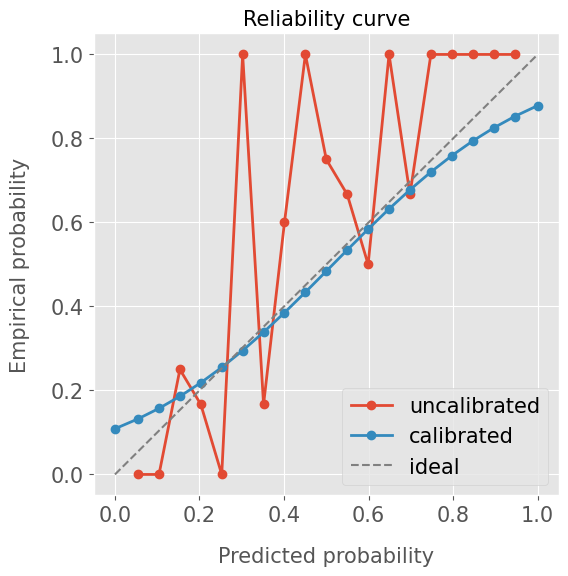

In [48]:
fig, ax = plt.subplots(1, figsize=(6, 6))

ax.plot(pred_probs_midpoints, empirical_probs, lw=2., marker="o", label="uncalibrated")
ax.plot([0.0] + pred_probs_midpoints + [1.0], calibrated_probs, lw=2., marker="o", label="calibrated")
ax.plot([0,1], [0,1], linestyle='--', color="gray", label="ideal")
ax.set_xlabel("Predicted probability", fontsize=fontsize, labelpad=15)
ax.set_ylabel("Empirical probability", fontsize=fontsize, labelpad=15)
adjustAxeProperties(ax, fontsize, 0, fontsize, 0)
ax.legend(loc="best", fontsize=fontsize)
ax.set_title("Reliability curve", fontsize=fontsize)